# Assignment 4: LSTM

Implement a vanilla LSTM in numpy according to the forward pass formulas below
* with bias units
* without a forget gate 
* with batch learning, without using a separate loop for batches
* Use sigmoid as i/o activation and tanh as forget-gate and output activation. 
* Use MSE loss for training and train 2000 epochs
* Verify with gradient checking

## Notation info

* i = input gate
* o = output gate
* z = forget gate
* c = cell state
* h = output state

$\odot$ = multiply in numpy, using * 

$\cdot$ = dot product in numpy, done with @

## Formulas

$$
\begin{aligned}
  \mathbf{i}(t) &= sigmoid(\mathbf{x}(t) \cdot \mathbf{W}_i + \mathbf{h}(t-1) \cdot \mathbf{R}_i + \mathbf{b}_i) \\
  \mathbf{o}(t) &= sigmoid(\mathbf{x}(t) \cdot \mathbf{W}_o + \mathbf{h}(t-1) \cdot \mathbf{R}_o + \mathbf{b}_o) \\
  \mathbf{z}(t) &= tanh(\mathbf{x}(t) \cdot \mathbf{W}_z + \mathbf{h}(t-1) \cdot \mathbf{R}_z + \mathbf{b}_z) \\
  \mathbf{c}(t) &= \mathbf{c}(t-1) + \mathbf{i}(t) \odot \mathbf{z}(t) \\
  \mathbf{h}(t) &= \mathbf{o}(t) \odot tanh(\mathbf{c}(t))
\end{aligned}
$$

Checking for Wz
Checking for Wi
Checking for Wo
Checking for Rz
Checking for Ri
Checking for Ro
Checking for bz
Checking for bi
Checking for bo
Checking for V
Checking for bv


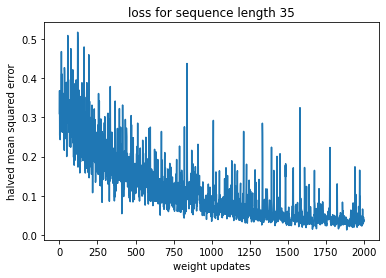

In [4]:
%matplotlib inline
import numpy as np
from numpy import tanh
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
from collections import defaultdict

def sigmoid_(x): return sigmoid(x) * (1-sigmoid(x))
def tanh_(x): return (1-tanh(x)**2)

class LSTM(object):
    def __init__(self, n_input, n_cells, n_output):
        # init weights and biases
        self.n_input = n_input
        self.n_cells = n_cells
        self.n_output = n_output
        self.Wz, self.Wi, self.Wo = \
            np.random.normal(scale=0.1, size=(3, n_input, n_cells))
        self.Rz, self.Ri, self.Ro = \
            np.random.normal(scale=0.1, size=(3, n_cells, n_cells))
        self.bz, self.bi, self.bo = np.zeros((3, n_cells, 1))
        self.V = np.random.normal(scale=0.1, size=(n_cells, n_output))
        self.bv = np.zeros((n_output, 1))
        
        self.params  = ('Wz', 'Wi', 'Wo', 'Rz', 'Ri', 'Ro', 'bz', 'bi', 'bo', 'V', 'bv')
        self.x, self.i, self.o, self.z, self.c, self.h = dict(), dict(), dict(), dict(), dict(), dict()
        self.reset_gradients()
    
    def reset_gradients(self):
        for p in self.params:  # transposed gradients for easier collection/notation
            # init gradients for e.g. self.Wz as self.g_Wz (transposed)
            setattr(self, 'g_' + p, np.zeros_like(getattr(self, p).T))
    
    def forward(self, x):
        # init fields
        self.seq_len, self.n_batch, _ = x.shape
        self.x = x
        self.h, self.c, self.i, self.o, self.c = np.zeros((5, self.seq_len, self.n_batch, self.n_cells))
        # function-local temporary variables
        c, h = np.zeros((2, self.n_batch, self.n_cells))

        # forard pass loop
        for t in range(self.seq_len):
            i = sigmoid(x[t] @ self.Wi + h @ self.Ri + self.bi.T)
            o = sigmoid(x[t] @ self.Wo + h @ self.Ro + self.bo.T)
            z = tanh   (x[t] @ self.Wz + h @ self.Rz + self.bz.T)
            c = c + i * z
            h = o * tanh(c)
            self.i[t], self.o[t], self.z[t], self.c[t], self.h[t] = i, o, z, c, h  # store all          
        self.y = (h @ self.V + self.bv.T)
        return self.y

    
    def backward(self, y_hat, y):
        # y and y_hat must be of shape (batch_size, n_output)
        assert y_hat.shape[1] == self.n_output, (y_hat.shape[1], self.n_output)
        assert len(y_hat.shape) == 2, y_hat.shape
        assert y_hat.shape == y.shape, (y_hat.shape, y.shape)
        
        self.reset_gradients()
        dL_dy = (y_hat - y)
        seq_last = self.seq_len-1
        loss = (dL_dy**2).mean(0).sum()  # mse, just like in gradient checking

        self.g_bv = np.array([dL_dy.sum(axis=0)])
        self.g_V =  dL_dy.T @ self.h[-1]
        
        dL_dc = np.zeros((self.n_batch, self.n_cells))
        dL_dh = dL_dy @ self.V.T
        
        for t in reversed(range(self.seq_len)):
            # print(f"iteration {t}")
            i, o, z, c, x = self.i[t], self.o[t], self.z[t], self.c[t], self.x[t]
            h1 = self.h[t-1] if t != 0 else np.zeros_like(self.h[t])
            
            # partial derivatives of dL w.r.t. [o,c,i,z]
            dL_dc+= dL_dh * o * tanh_(c)
            dL_di = dL_dc * z
            dL_do = dL_dh * tanh(c)
            dL_dz = dL_dc * i

            # backwards of forward pass
            delta_i = (dL_di * sigmoid_(x @ self.Wi + h1 @ self.Ri + self.bi.T)).T
            delta_o = (dL_do * sigmoid_(x @ self.Wo + h1 @ self.Ro + self.bo.T)).T
            delta_z = (dL_dz * tanh_   (x @ self.Wz + h1 @ self.Rz + self.bz.T)).T
            
            # sum up gradients
            self.g_bi += delta_i.T.sum(axis=0)
            self.g_bo += delta_o.T.sum(axis=0)
            self.g_bz += delta_z.T.sum(axis=0)
            self.g_Ri += delta_i @ h1
            self.g_Ro += delta_o @ h1
            self.g_Rz += delta_z @ h1
            self.g_Wi += delta_i @ x
            self.g_Wo += delta_o @ x
            self.g_Wz += delta_z @ x
            
            # reuse pre-activations of last iteration (which are only available after 1st step)
            dL_dh = delta_i.T @ self.Ri.T + delta_o.T @ self.Ro.T + delta_z.T @ self.Rz.T
            
            if t == 0:
                self.dL_dc0 = np.sum(np.abs(dL_dc))
        
        for p in self.params:
            gradient = getattr(self, 'g_' + p) 
            gradient /= self.n_batch
        return loss
                
    
    def gradient_check(self, x, y, eps=1e-5, thresh=1e-5, verbose=False):
        for p in self.params:
            print("Checking for",p)
            w = getattr(self, p)
            g = getattr(self, 'g_' + p)
            
            if verbose: print(p)
            
            for i in range(w.shape[0]):
                for j in range(w.shape[1]):
                    w_orig = w[i,j]
                    w[i,j] = w_orig + eps/2
                    hi = (0.5 * (y - self.forward(x))**2).mean(0).sum()
                    w[i,j] = w_orig - eps/2
                    lo = (0.5 * (y - self.forward(x))**2).mean(0).sum()
                    w[i,j] = w_orig
                    n = (hi - lo) / eps
                    
                    if verbose: 
                        print('analytical=%f numerical=%f difference=%f' % (g[j,i], n, abs(n - g[j,i])))
                    
                    if abs(n - g[j,i]) > thresh:
                        fmt = (p, i, j, g[j,i], n)
                        raise Exception('gradient check failed at %s[%d,%d]: analytical=%f numerical=%f' % fmt)
    
    def update(self, eta):
        # update weights
        for p in self.params:
            w = getattr(self, p)
            w -= eta * getattr(self, 'g_' + p).T


def generate_samples(seq_length, batch_size, input_size):
    while True:
        x = np.random.uniform(low=-1, high=1, size=(seq_length, batch_size, input_size))
        y = x[0,:,:]
        yield x, y


def check_gradients():
    lstm = LSTM(3, 5, 3)
    data = generate_samples(seq_length=7, batch_size=2, input_size=3)
    
    for i, (x, y) in zip(range(1), data):
        y_hat = lstm.forward(x)
        lstm.backward(y_hat, y)
        lstm.gradient_check(x, y)

        
def train(seq_length=35, plot=True):
    iter_steps = 2000
    lr = 1e-1
    
    lstm = LSTM(1, 10, 1)
    data = generate_samples(seq_length=seq_length, batch_size=32, input_size=1)
    loss = []
    
    for i, (x, y) in zip(range(iter_steps), data):
        y_hat = lstm.forward(x)
        loss.append(lstm.backward(y_hat, y))
        lstm.update(lr)
    
    if plot:
        # plot learning curve
        plt.title('loss for sequence length %d' % seq_length)
        plt.plot(range(len(loss)), loss)
        plt.xlabel('weight updates')
        plt.ylabel('halved mean squared error')
        plt.show()
    else:
        return lstm.dL_dc0

np.random.seed(0xDEADBEEF)
check_gradients()
train()

# Visualize the |dL / dc(0)|

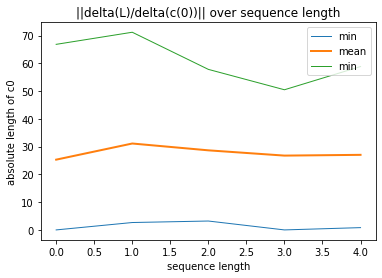

In [16]:
# repeat experiment 5x and plot min/max bands, as well as mean
data = np.array([[train(seq_len, plot=False) for seq_len in range(1,35)] for _ in range(5)])
datamin = data.min(axis=1)
datamean = data.mean(axis=1)
datamax = data.max(axis=1)

plt.title('||delta(L)/delta(c(0))|| over sequence length')
plt.plot(datamin, linewidth=1, label="min")
plt.plot(datamean,linewidth=2, label="mean")
plt.plot(datamax, linewidth=1, label="min")
plt.legend(loc="upper right")
plt.xlabel('sequence length')
plt.ylabel('absolute length of c0')
plt.show()

### Discussion

Definition:
$$\frac{\partial L}{\partial \mathbf{c}(0)} = 
\frac{\partial L}{\partial \mathbf{y}(0)} 
diag(o(0) \odot h'(c(0)) + \frac{\partial L}{\partial \mathbf{c}(1)}$$

This means the $\frac{\partial L}{\partial \mathbf{c}(0)}$ is a fully backpropagated partial derivative that sums up all previous activations of $\frac{\partial L}{\partial \mathbf{c}(t)}$.

For longer sequence lengths, the vector $\frac{\partial L}{\partial \mathbf{c}(0)}$ in a network trained for the memory task (output = 0th input), the c0 should stay roughly constantly high, meaning that it learned to already strongly remember the 0th input unit based on the constant error carousel being in its init-state.

This means that no vanishing gradient is happening, unlike in ex2 where the loss rises with length and therefore also the $\left\|\frac{\partial L}{\partial \mathbf{a}(0)}\right\|$ (the a(t) in RNNs is roughly equivalent to c(t)  in RNNs) increased with sequence length.

However, we see that the min/max range can be quite wide, as it depends on the loss of a batch.